In [ ]:
pip install pandas scikit-learn rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 24.7 MB/s eta 0:00:00


In [ ]:
import json
import random

data = []
for _ in range(5000):
    reactant_smiles = ''.join(random.choices(['C', 'O', 'N'], k=random.randint(3, 10)))
    product_smiles = ''.join(random.choices(['C', 'O', 'N'], k=random.randint(3, 10)))
    temperature = random.randint(20, 250)
    pressure = random.uniform(1, 10)
    solvent = random.choice(['Water', 'Ethanol', 'Methanol', 'Acetone', 'DMSO'])
    catalyst = random.choice(['HCl', 'NaOH', 'Pt', 'Pd', 'CuSO4', 'None'])
    yield_percent = round(random.uniform(50, 99), 2)
    data.append({
        "Reactant_SMILES": reactant_smiles,
        "Product_SMILES": product_smiles,
        "Temperature_C": temperature,
        "Pressure_atm": pressure,
        "Solvent": solvent,
        "Catalyst": catalyst,
        "Yield_Percent": yield_percent
    })

with open('synthetic_reaction_data.json', 'w') as f:
    json.dump(data, f)


In [ ]:
from rdkit.Chem import rdMolDescriptors

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((1, 1024))
    return np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))


In [ ]:
!pip install --upgrade rdkit


In [ ]:
import warnings
import sys
import os

warnings.filterwarnings("ignore")

sys.stderr = open(os.devnull, 'w')

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
import json

with open('synthetic_reaction_data.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1024)
    morgan_fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return np.array(morgan_fp)

fingerprints = df['Reactant_SMILES'].apply(smiles_to_fingerprint)
fingerprint_array = np.stack(fingerprints.values)

encoder = OneHotEncoder(sparse_output=False)
solvent_encoded = encoder.fit_transform(df[['Solvent']])
catalyst_encoded = encoder.fit_transform(df[['Catalyst']])

scaler = StandardScaler()
df[['Temperature_C', 'Pressure_atm']] = scaler.fit_transform(df[['Temperature_C', 'Pressure_atm']])

X = np.hstack([solvent_encoded, catalyst_encoded, df[['Temperature_C', 'Pressure_atm']].values, fingerprint_array])
y = df['Yield_Percent'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

sys.stderr = sys.__stderr__


Mean Squared Error: 213.72268864386


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=5, cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best MSE found: ", -random_search.best_score_)

best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized Mean Squared Error: {mse}')


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best MSE found:  206.48420276927703
Optimized Mean Squared Error: 208.88687533067858


R-squared: -0.0008026369260976107


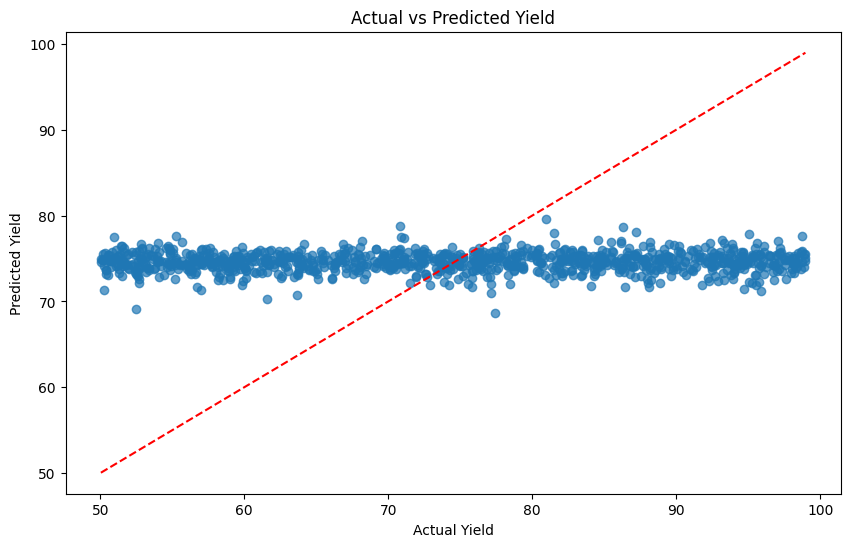

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.show()


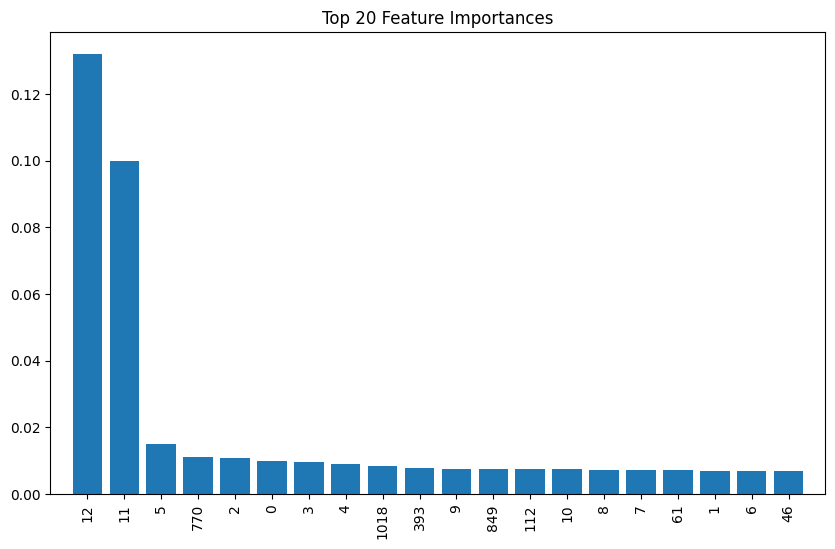

In [ ]:

plt.figure(figsize=(10, 6))
plt.title(f"Top {N} Feature Importances")
plt.bar(range(N), importances[indices[:N]], align="center")
plt.xticks(range(N), [str(indices[i]) for i in range(N)], rotation=90)
plt.xlim([-1, N])
plt.show()


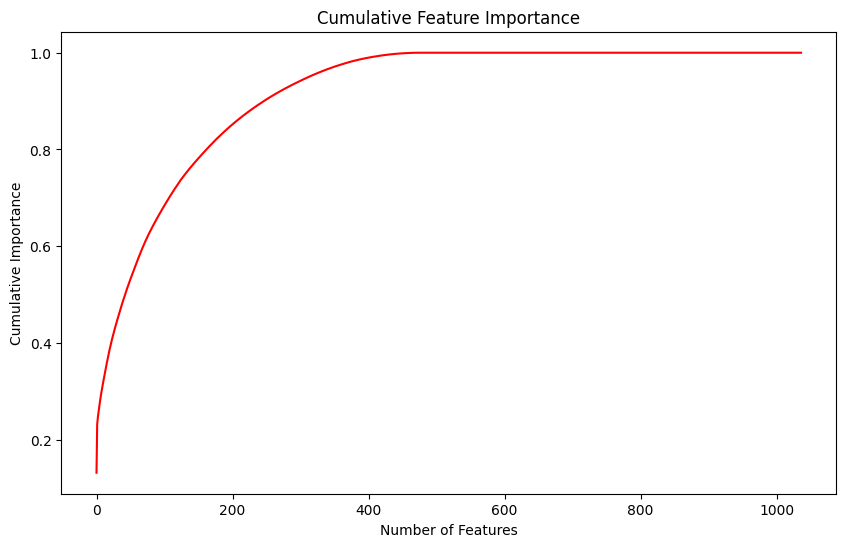

In [ ]:
cumulative_importance = np.cumsum(importances[indices])

plt.figure(figsize=(10, 6))
plt.title("Cumulative Feature Importance")
plt.plot(range(len(cumulative_importance)), cumulative_importance, 'r-')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.show()


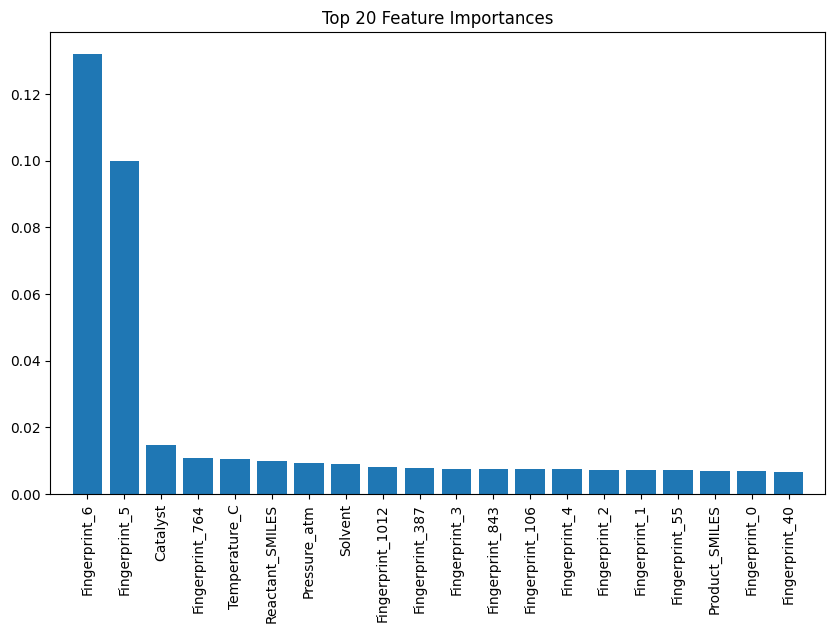

In [ ]:
feature_names = list(df.columns[:-1]) + ["Fingerprint_" + str(i) for i in range(fingerprint_array.shape[1])]

plt.figure(figsize=(10, 6))
plt.title(f"Top {N} Feature Importances")
plt.bar(range(N), importances[indices[:N]], align="center")
plt.xticks(range(N), [feature_names[indices[i]] for i in range(N)], rotation=90)
plt.xlim([-1, N])
plt.show()


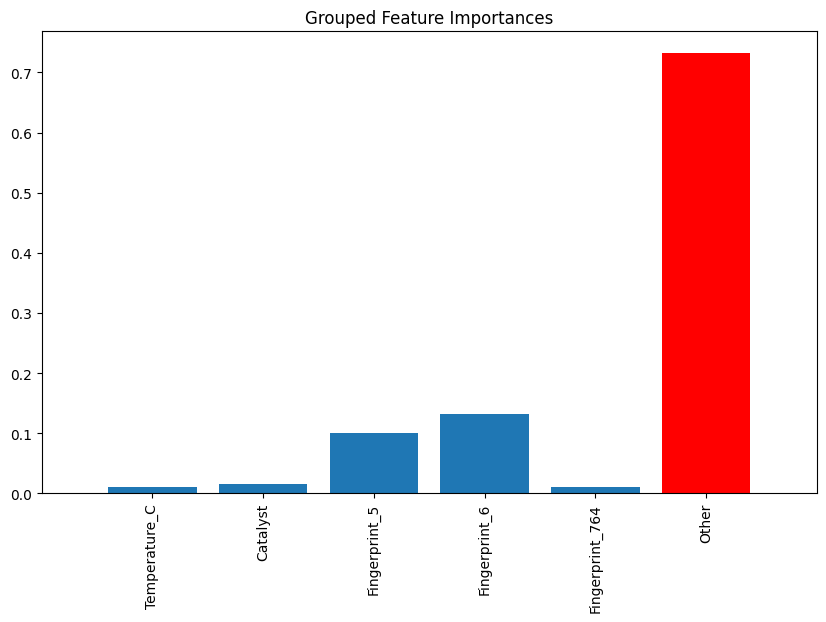

In [ ]:
important_indices = np.where(importances > threshold)[0]
other_importance = np.sum(importances[importances <= threshold])

plt.figure(figsize=(10, 6))
plt.title("Grouped Feature Importances")
plt.bar(range(len(important_indices)), importances[important_indices], align="center")
plt.bar(len(important_indices), other_importance, align="center", color='red')
plt.xticks(list(range(len(important_indices))) + [len(important_indices)],
           [feature_names[i] for i in important_indices] + ["Other"], rotation=90)
plt.xlim([-1, len(important_indices) + 1])
plt.show()


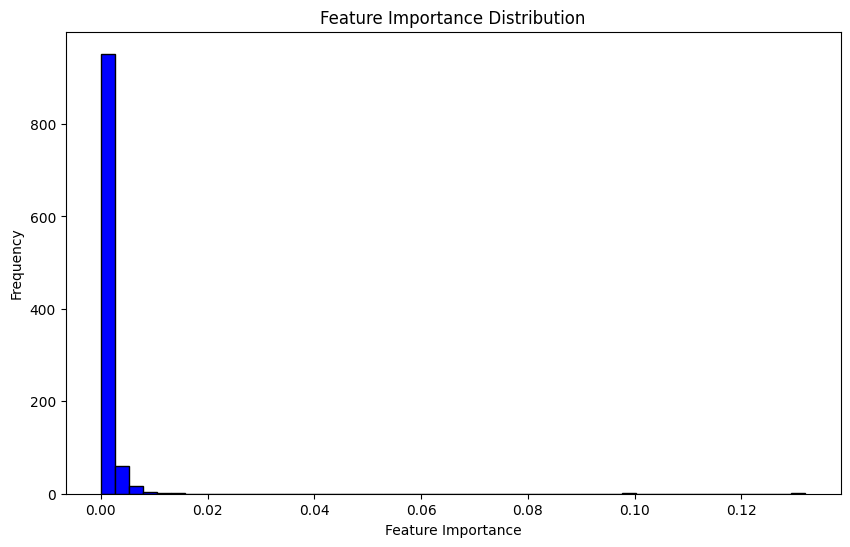

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importance Distribution")
plt.hist(importances, bins=50, color='blue', edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.show()


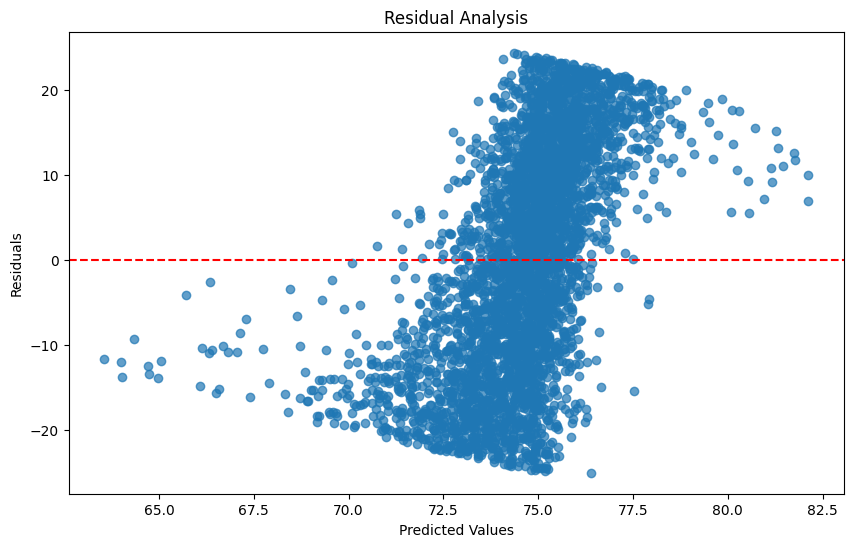

In [ ]:
y_train_pred = best_rf.predict(X_train)

residuals = y_train - y_train_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 26.4 MB/s eta 0:00:00


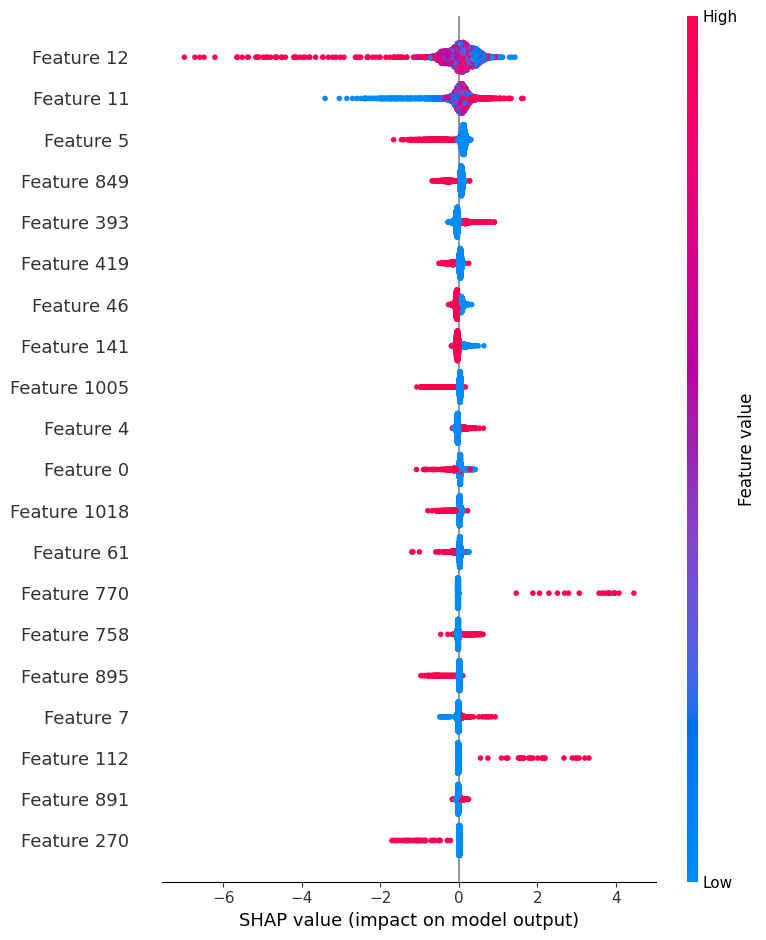

In [ ]:
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)


In [ ]:
import joblib

joblib.dump(best_rf, 'optimized_random_forest_model.pkl')


['optimized_random_forest_model.pkl']